# Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import joblib

In [ ]:
df = pd.read_csv("final_dataset.csv")
print(df.shape)
df.head()

(23040, 10)


,state_encoded,district_encoded,market_encoded,commodity_encoded,commodity_category_encoded,year,month,day,dayofweek,modal_price
0,7,12,308,112,6,2023,7,27,3,4350.0
1,7,12,308,66,6,2023,7,27,3,2450.0
2,7,12,308,28,6,2023,7,27,3,2700.0
3,7,12,308,35,6,2023,7,27,3,7250.0
4,7,12,308,51,6,2023,7,27,3,8850.0


In [ ]:
# Createing a copy for safe side.
final_dataset = df.copy()

# Model Building

c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib

✅ Model Comparison:

               Model          MAE         RMSE        R2      MAPE(%)
0  Linear Regression  2918.758726  5271.302028  0.037869   487.714917
1      Random Forest   892.130920  2327.968366  0.812348    58.377216
2            XGBoost  1030.205679  2140.085851  0.841415   188.320506
3     Neural Network  2636.818772  4995.627610  0.135871   404.773773
4              ARIMA  3188.530865  6745.229526 -0.034299  2584.013042


C:\Users\chara\AppData\Local\Temp\ipykernel_24244\826984413.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
C:\Users\chara\AppData\Local\Temp\ipykernel_24244\826984413.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, ax=ax, palette="viridis")
C:\Users\chara\AppData\Local\Temp\ipykernel_24244\826984413.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


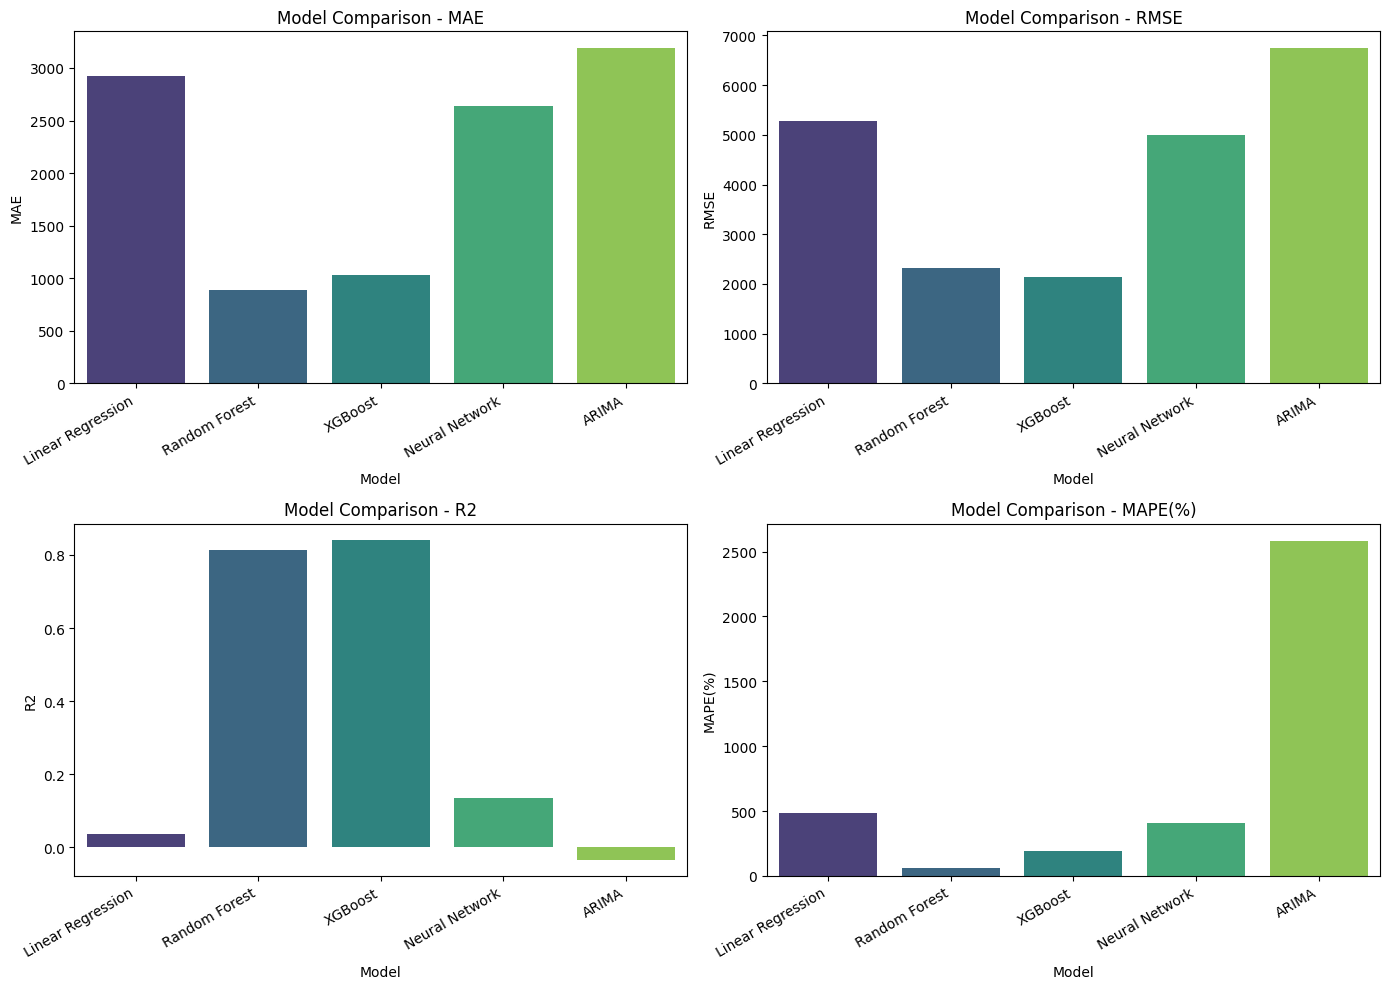

In [ ]:
# Helper function: evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100  # avoid div/0
    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE(%)": mape,
    }

# Prepare data
X = df.drop(["modal_price", "arrival_date"], axis=1, errors="ignore")
y = df["modal_price"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "Linear Regression"))

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "Random Forest"))

# 3. XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "XGBoost"))

# 4. Neural Network (MLP)
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "Neural Network"))

# 5. ARIMA (time series only)
# Recreate arrival_date if missing
if "arrival_date" not in final_dataset.columns:
    final_dataset["arrival_date"] = pd.to_datetime(final_dataset[["year", "month", "day"]])

ts_df = final_dataset[["arrival_date", "modal_price"]].sort_values("arrival_date")

split_index = int(len(ts_df) * 0.8)
train, test = ts_df.iloc[:split_index], ts_df.iloc[split_index:]

arima = ARIMA(train["modal_price"], order=(5, 1, 2))
arima_fit = arima.fit()
forecast = arima_fit.forecast(steps=len(test))

results.append(evaluate_model(test["modal_price"], forecast, "ARIMA"))

# Results DataFrame
results_df = pd.DataFrame(results)
print("✅ Model Comparison:\n")
print(results_df)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["MAE", "RMSE", "R2", "MAPE(%)"]

for ax, metric in zip(axes.flatten(), metrics):
    sns.barplot(x="Model", y=metric, data=results_df, ax=ax, palette="viridis")
    ax.set_title(f"Model Comparison - {metric}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


- Best R² (0.84) → ✅ XGBoost
- Best RMSE (2140) → ✅ XGBoost
- Best MAE (892) → ✅ Random Forest
- Worst (negative R², high errors) → ❌ ARIMA
- Linear Regression & ANN → not performing well (likely underfitting).

In [ ]:
# Add Accuracy (%) = R2 * 100
results_df["Accuracy(%)"] = results_df["R2"] * 100

print("✅ Model Comparison with Accuracy (%):\n")
results_df

✅ Model Comparison with Accuracy (%):



,Model,MAE,RMSE,R2,MAPE(%),Accuracy(%)
0,Linear Regression,2918.758726,5271.302028,0.037869,487.714917,3.786890
1,Random Forest,892.130920,2327.968366,0.812348,58.377216,81.234826
2,XGBoost,1030.205679,2140.085851,0.841415,188.320506,84.141546
3,Neural Network,2636.818772,4995.627610,0.135871,404.773773,13.587103
4,ARIMA,3188.530865,6745.229526,-0.034299,2584.013042,-3.429862


- XGBoost → Best performer (84.14% accuracy), lowest RMSE.
- Random Forest → Very strong & stable (81.23% accuracy) with lower MAE than XGBoost.
- Neural Network → Underfitting (low accuracy ~13.5%).
- Linear Regression → Performs poorly (3.7%).
- ARIMA → Not suitable here (negative accuracy).

C:\Users\chara\AppData\Local\Temp\ipykernel_24244\940209877.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df["Model"], rotation=45, ha="right")
C:\Users\chara\AppData\Local\Temp\ipykernel_24244\940209877.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df["Model"], rotation=45, ha="right")
C:\Users\chara\AppData\Local\Temp\ipykernel_24244\940209877.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df["Model"], rotation=45, ha="right")
C:\Users\chara\AppData\Local\Temp\ipykernel_24244\940209877.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

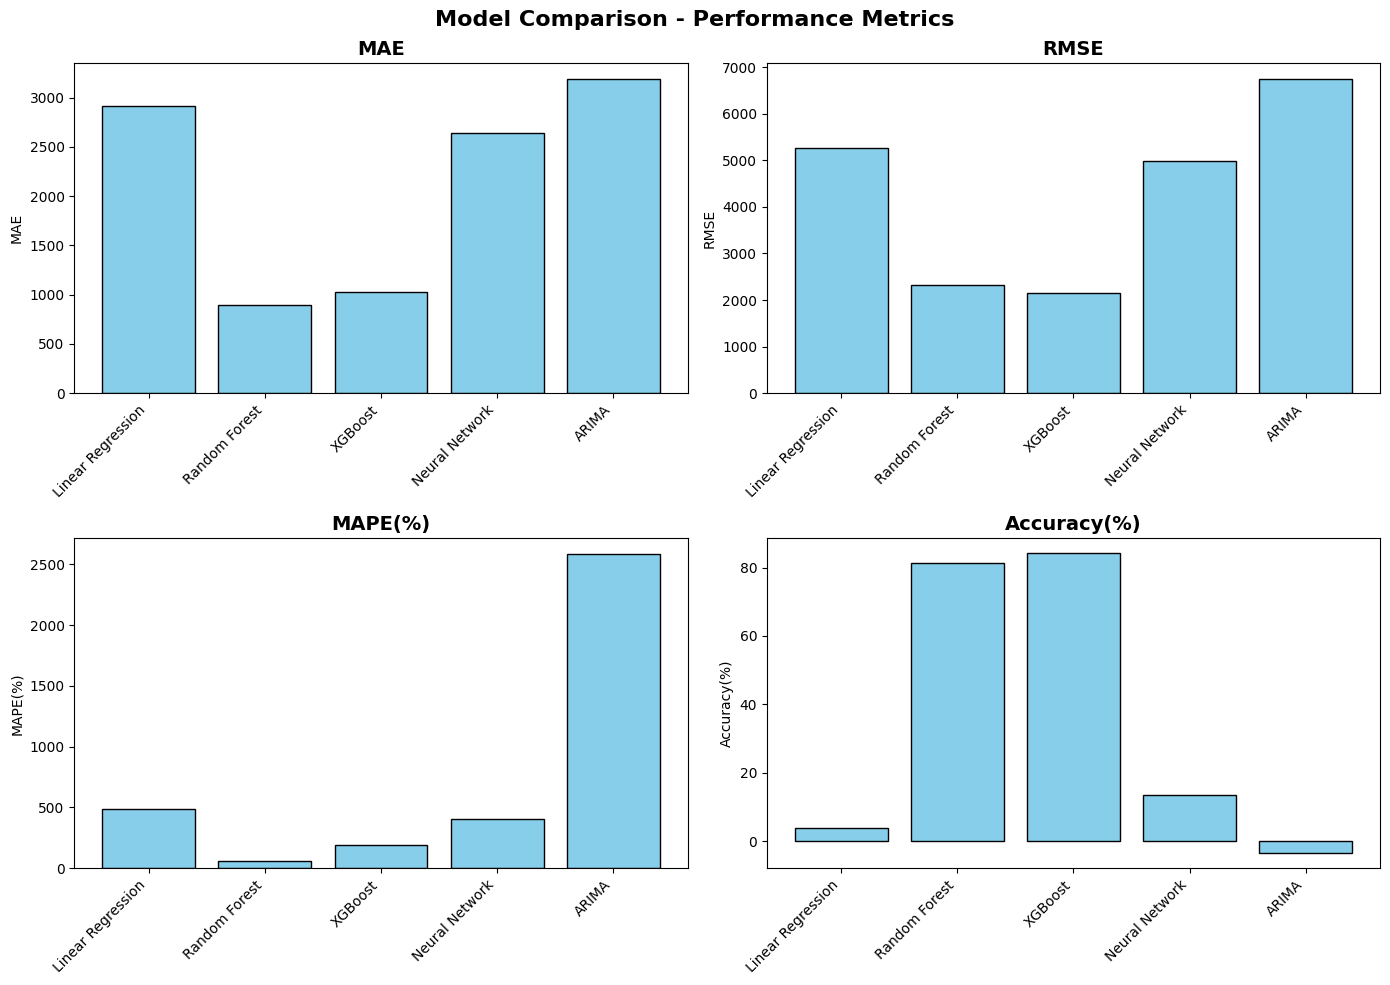

In [ ]:
# Select metrics to plot
metrics = ["MAE", "RMSE", "MAPE(%)", "Accuracy(%)"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(results_df["Model"], results_df[metric], color="skyblue", edgecolor="black")
    axes[i].set_title(metric, fontsize=14, fontweight="bold")
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(results_df["Model"], rotation=45, ha="right")

plt.suptitle("Model Comparison - Performance Metrics", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Models Testing

In [ ]:
# Pick some test samples
sample_X = X_test.iloc[:5]
sample_y = y_test.iloc[:5]

# Predictions (rounded to int)
preds = {
    "Actual": sample_y.values.astype(int),
    "Linear Regression": np.round(lr.predict(sample_X)).astype(int),
    "Random Forest": np.round(rf.predict(sample_X)).astype(int),
    "XGBoost": np.round(xgb.predict(sample_X)).astype(int),
    "ARIMA": np.round(arima.forecast(steps=5)).astype(int)
}

# Combine into DataFrame
preds_df = pd.DataFrame(preds)
print(preds_df)

       Actual  Linear Regression  Random Forest  XGBoost  ARIMA
18432    1950               3019           1822     1763   2431
18433    1185               2755           1151     1284   2337
18434    3000               3590           2890     3440   2120
18435    6000               4874           6398     6776   2300
18436    2060               4161           2058     2053   2470


c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chara\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Save models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(xgb, "xgboost_model.pkl")

print("✅ Models saved successfully!")


✅ Models saved successfully!


In [ ]:
# Load models and test
rf_loaded = joblib.load("random_forest_model.pkl")
xgb_loaded = joblib.load("xgboost_model.pkl")

# Test loading
print("Random Forest Test Prediction:", rf_loaded.predict(X_test.iloc[:1]))
print("XGBoost Test Prediction:", xgb_loaded.predict(X_test.iloc[:1]))


Random Forest Test Prediction: [1821.6]
XGBoost Test Prediction: [1762.842]
